In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs

In [2]:
output = os. getcwd()+"/output/scatt"

In [3]:
output

'/tf/Thesis/output/scatt'

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 128 * 128*3
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [5]:
training_data = []

def create_training_data():
    for img in os.listdir(output):  
        try:
            img_array = cv2.imread(os.path.join(output,img))  # convert to array
            img_array = img_array/ 255
            training_data.append(img_array)  # add this to our training_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass
        
create_training_data()
training_data = np.array(training_data)

MemoryError: Unable to allocate 2.31 GiB for an array with shape (6300, 128, 128, 3) and data type float64

In [ ]:
class SamplingLayer(tf.keras.layers.Layer):
    def __init__(self):#, z_mean, z_log_sigma):
        super(SamplingLayer, self).__init__()
        #self.z_mean = z_mean
        #self.z_log_sigma = z_log_sigma
        
    def call(self, inputs):
        #epsilon = K.random_normal(shape=(K.shape(self.z_mean)[0], latent_dim), mean=0., stddev=0.1))
        z_mean, z_log_sigma = inputs
        return z_mean + K.exp(z_log_sigma) * K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)


In [ ]:
original_dim = 128 * 128 * 1
intermediate_dim = 128
latent_dim = 3

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=None)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)
# z = layers.Lambda(sampling)([z_mean, z_log_sigma])
z = SamplingLayer()([z_mean, z_log_sigma])
# Create encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

In [ ]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
X_train, X_test = train_test_split(training_data, test_size=0.2)
#x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
#x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


In [ ]:
X_train.shape
del training_data

In [ ]:
X_train.shape

In [ ]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())


vae.fit(X_train, X_train,epochs=50,batch_size=32)

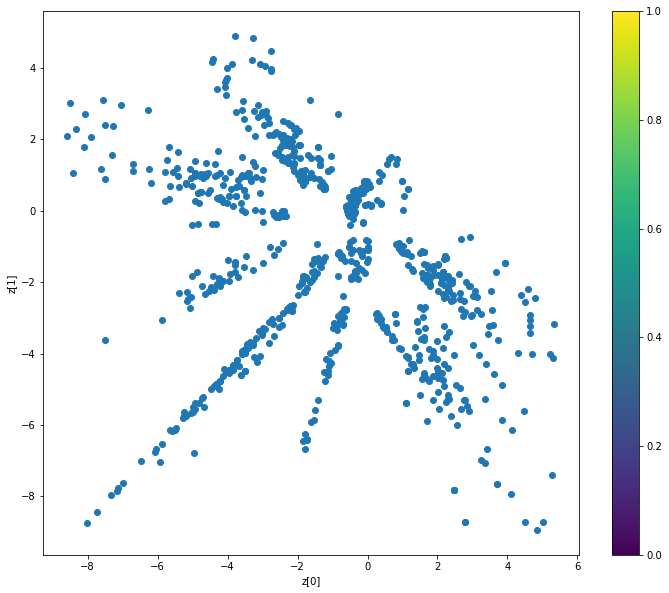

In [18]:
def plot_label_clusters(encoder, decoder, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X_test)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    


plot_label_clusters(encoder, decoder, X_test)

In [19]:
tfjs.converters.save_keras_model(encoder, "./vae/public/encoder")
tfjs.converters.save_keras_model(decoder, "./vae/public/decoder")

In [49]:
def plot_label_clusters(encoder, decoder, data):
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(test_img)
    return z
    

test_img = X_test[350].reshape(1,128,128,3)

z = plot_label_clusters(encoder, decoder, X_test)

print('latent sample:\n', z[0])

latent sample:
 [[ 3.0816002 -2.2539792  3.9768164]]


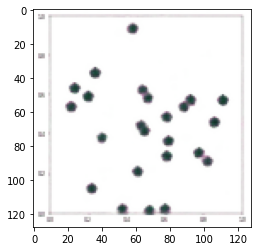

In [50]:
def decode_embedding(z, decoder):
    return decoder.predict(z)

# reconstruct original image using latent space
ret = decode_embedding(z, decoder)
plt.imshow(ret[0])
plt.show()

<Figure size 432x288 with 0 Axes>

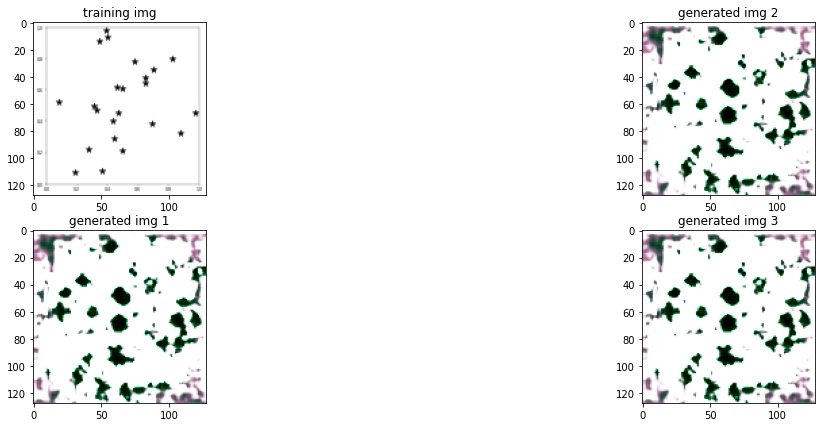

In [51]:
def generate_new_images_vae(nb=4):
    plt.clf();
    f, ax = plt.subplots(2, nb//2, figsize=(20,7));
    for i in range(nb):
        z1 = np.random.rand(7,7)
        z1 =np.array([[10,-2,0]])
        ret = decode_embedding(z1, decoder)
        ax[i%2][i//2].imshow(ret[0])
        ax[i%2][i//2].set_title('generated img {}'.format(i))
    ax[0][0].imshow(X_test[300])
    ax[0][0].set_title('training img')
    
generate_new_images_vae()

In [37]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0]
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size,]  = digit


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


IndexError: too many indices for array